In [355]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from os.path import join
import matplotlib as mpl
from IPython.display import clear_output

In [ ]:
# reset default matplotlib params
from matplotlib.pyplot import rcParams
mpl.rcParams.update(mpl.rcParamsDefault)

The network consists of a single layer of 180 neurons that receive activation from both exogenous inputs and lateral connections.

### Input activation
#### equation (7)

On simulated trial *n*, the mean input activation to neuron *i* is a function of the difference between the target location *$\theta(n)$* and the preferred direction of the neuron *$\theta_i^*$*


target: *$I_i(n)$*, mean activation of unit i  
baseline: *$I_0$*, baseline input rate  
gain: *$\gamma$*, input gain  
target: *$\theta(n)$*,  target location  
preference: *$\theta_i^*$*, prefered direction of unit i  
spread: *$\omega_I$*, spread of input activation (full-width-half-magnitude / FWHM)  


In [70]:
# define input activation function

def input_activation(target, pref_dirs, baseline=5, gain=13.4, spread=18.9):
    activation = baseline + gain * np.exp(-np.log(2) * ((target-pref_dirs) / (spread/2))**2)    
    return activation


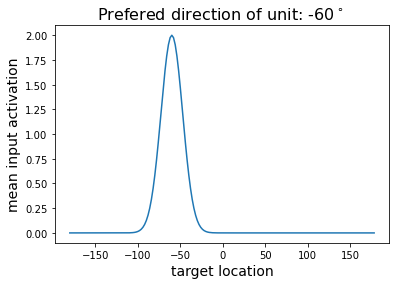

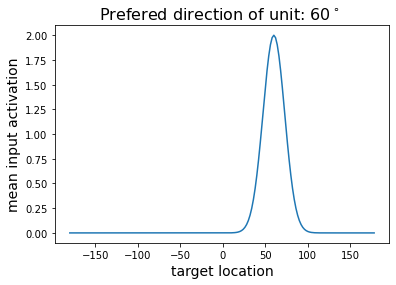

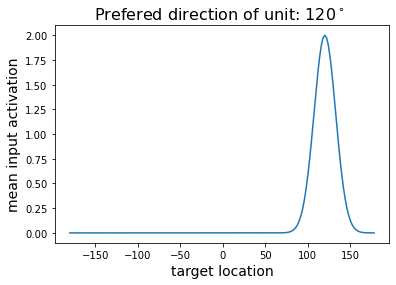

In [73]:
# Plot activation profile for and example unit

def plot_input_activation_profile(pref_dirs, baseline=0, gain=13.4, spread=18.9):
    # calculate activation for all orientations between 0 and 360 degrees
    target = np.arange(-180,180,2)
    activation = np.zeros(len(target))

    for ii in range(len(target)):
        activation[ii] = input_activation(target[ii], pref_dirs, 
                                          baseline=baseline, gain=gain, spread=spread)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(target, activation)
    plt.xlabel('target location', fontsize=14)
    plt.ylabel('mean input activation', fontsize=14)
    plt.title('Prefered direction of unit: %d$^\circ$ ' %pref_dirs, fontsize=16)
    
for pref in[-60, 60, 120]:
    plot_input_activation_profile(pref, baseline=0, gain=2, spread=30)

### Trial iteration
#### equation (8)

Add Gaussian noise to input activation

In [124]:
def calc_covariance(activation, fano=2, psi=5.49, rho=0.1):
    # calc variance
    variance =  fano * activation
    sigma = np.sqrt(variance)
    
    # calc covariance as product of sigma_i and sigma_j (without fall-off w/ distance)
    sigma_i_sigma_j = np.outer(sigma, sigma)
    
    # calc fall-off with distance between preffered angles 
    covariance = np.zeros_like(sigma_i_sigma_j)
    for i, pref_i in enumerate(pref_dirs):
        for j, pref_j in enumerate(pref_dirs):
            if i == j:
                covariance[i,j] = variance[i]
            else:
                covariance[i,j] =  sigma_i_sigma_j[i,j] * rho * 0.5**(2*(abs(pref_i-pref_j)-2)/psi)
    
    
    return covariance
    

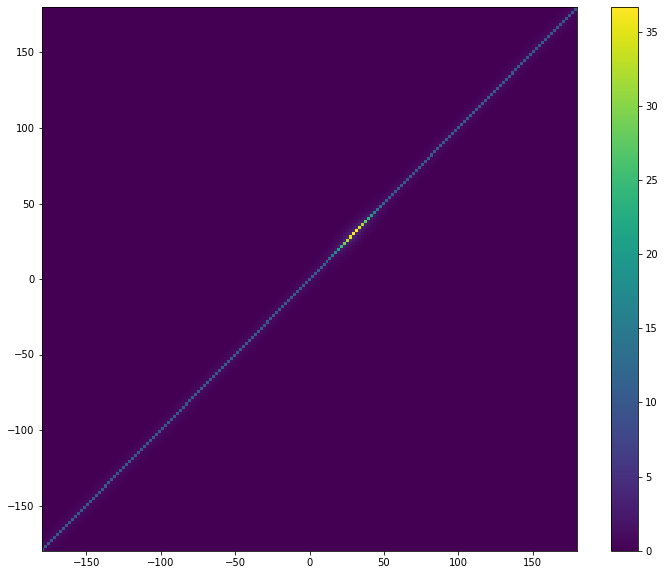

In [125]:
# define parameters
N_UNITS = 180 # number of units in the network
PREF_DIRS = np.linspace(-180,180,N_UNITS) # preferred direction of units
TARGET = 30 # target angle

# calc activation
activation = np.zeros(len(PREF_DIRS))
for ii, pref_i in enumerate(PREF_DIRS):
    activation[ii] = input_activation(TARGET, pref_i) 

# calc covariance
covariance = calc_covariance(activation, fano=2, psi=5.45, rho=0.1)

# plot covariance
plt.figure(figsize=[12,10])
plt.pcolormesh(PREF_DIRS, PREF_DIRS, covariance)
plt.colorbar()
plt.show()

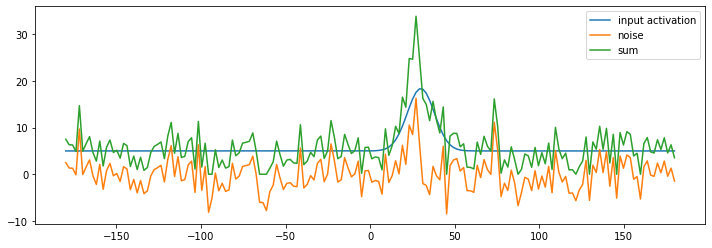

In [126]:
# calculate noise
noise = multivariate_normal.rvs(np.zeros_like(PREF_DIRS), covariance, size=1)

# add noise to input activation
activation_n_noise = activation + noise

# take positive part
activation_n_noise[activation_n_noise<0] = 0

# plot activation
plt.figure(figsize=[12,4])
plt.plot(PREF_DIRS, activation,label='input activation')
plt.plot(PREF_DIRS, noise,label='noise')
plt.plot(PREF_DIRS, activation_n_noise,label='sum')
plt.legend()


In [79]:
# define noise function

def add_noise(activation):
    covariance = calc_covariance(activation)
    
    # calculate noise
    noise = multivariate_normal.rvs(np.zeros_like(pref_dirs), covariance, size=1)

    # add noise to input activation
    activation_n_noise = activation + noise

    # take positive part
    activation_n_noise[activation_n_noise<0] = 0
    
    return activation_n_noise


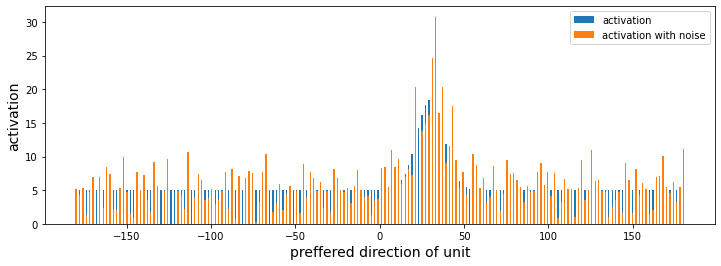

In [84]:
# test noise function

temp = add_noise(activation)

# plot activation
plt.figure(figsize=[12,4])
plt.bar(PREF_DIRS, activation,label='activation')
plt.bar(PREF_DIRS, temp,label='activation with noise')
plt.xlabel('preffered direction of unit', fontsize=14)
plt.ylabel('activation', fontsize=14)
plt.legend()
plt.show()

### Lateral connection strength
#### equation (9)

The initial connection strength between a pair of units is determined by the distance between the units’ preferred directions in the circular space (preferred directions were evenly spaced at delta = 2 degrees)  

###### variables
W_ij: *$W_{ij}$* lateral connection strength (unit j to unit i)  
pref_i: *$\theta_i^*$*, prefered direction of unit i  
pref_j: *$\theta_j^*$*, prefered direction of unit j  
spread: *$\omega_L$*, full-width-half-magnitude (FWHM)

In [9]:
# define lateral connection strength function

def connection_strength(pref_i, pref_j, spread=30):
    W_ij = np.exp(-np.log(2) * ((pref_i-pref_j) / (spread/2))**2)    
    return W_ij

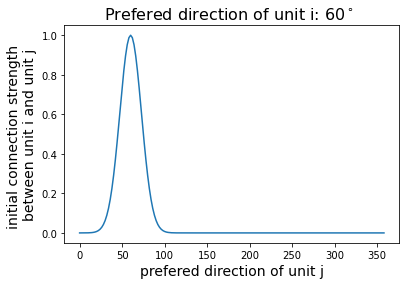

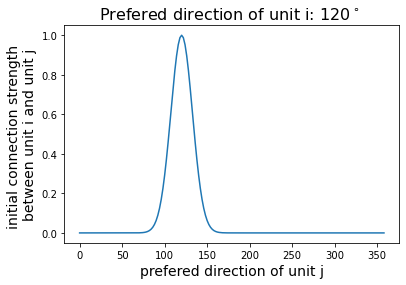

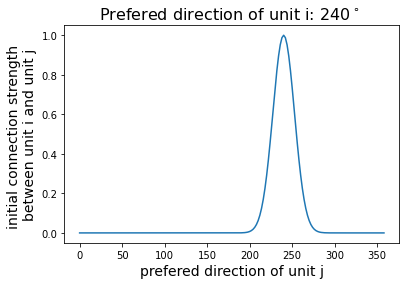

In [10]:
# Plot activation profile for and example unit

def plot_connection_strength_profile(pref_i, spread=12):
    # calculate connection
    pref_j = np.arange(0,360,2)
    W_ij = np.zeros(len(pref_j))

    for j in range(len(pref_j)):
        W_ij[j] = connection_strength(pref_i, pref_j[j], spread)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(pref_j, W_ij)
    plt.xlabel('prefered direction of unit j', fontsize=14)
    plt.ylabel('initial connection strength \nbetween unit i and unit j', fontsize=14)
    plt.title('Prefered direction of unit i: %d$^\circ$ ' %pref_i, fontsize=16)
    
for pref_i in[60, 120, 240]:
    plot_connection_strength_profile(pref_i, spread=30)

In [60]:
def calc_initial_weights(pref_dirs, spread=38.8):

    # calc weight between units
    initial_weights = np.zeros([len(pref_dirs), len(pref_dirs)])
    for i, pref_i in enumerate(pref_dirs):
        for j, pref_j in enumerate(pref_dirs):
            initial_weights[i,j] = connection_strength(i, j, spread=spread)
            
    return initial_weights
           

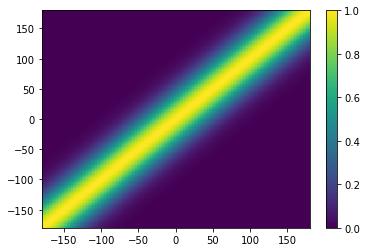

In [97]:
# create and plot an example initial weight matrix

# calc initial weights
pref_dirs = np.linspace(0,360,180)
initial_weights = calc_initial_weights(PREF_DIRS, spread=38.8)

# plot weights
plt.pcolormesh(PREF_DIRS, PREF_DIRS, initial_weights)
plt.colorbar()

### Total Activation
#### equation (10)

On each iteration *t*, the total activation for unit *i* was then computed as the sum of the input and recurrent activations

In [62]:
def total_activation(firing_rate, weights, theta, pref_dirs, 
                     baseline=5, gain=13.4, spread=18.9):    
    # calc input activation
    activation_raw = input_activation(theta, pref_dirs, baseline=baseline, gain=gain, spread=spread)
    activation = add_noise(activation_raw)
    
    # calc recurrent activation
    recurrent = np.dot(weights, firing_rate)
    
    # calc total activation
    total_activation = activation + recurrent
    
    return total_activation


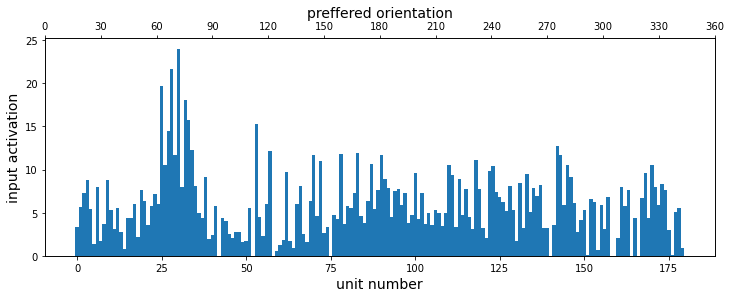

In [96]:
# calc input activation example

# define input angle
THETA = 60 
N_UNITS = 180

# calculate input activation of each unit
X = np.zeros_like(pref_dirs) # initial firing rates
U = lambda preference: total_activation(X, initial_weights, THETA, pref_dirs)
act = U(pref_dirs)

# plot input activation of each unit
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.bar(np.arange(180), act, width=1)

ax1.set_xlabel('unit number', fontsize=14)
ax1.set_ylabel('input activation', fontsize=14)

xx = np.linspace(0,360,13)
ax2.set_xticks(xx)
ax2.set_xticklabels([str(int(x)) for x in xx] )
ax2.set_xlabel('preffered orientation', fontsize=14)
plt.show()

### Firing Rates
#### equation (11)

Total activation was normalized on each iteration to obtain the new firing rates

In [92]:
def norm_activation(activation, a=0.002, b=0.001):
    norm = np.zeros_like(activation)
    for ii, act in enumerate(activation):
        norm[ii] = act**2 / (a + b * np.sum(activation**2))
        
    return norm  

### Hebbian learning rule
#### equation (12) 

After each iteration, the recurrent weights Wij were updated using a
normalized Hebbian learning rule [(Oja, 1982)](https://link.springer.com/article/10.1007/BF00275687)

beta: *$\beta$* learning rate  
alpha: *$\alpha$* normalization parameter  
weights: *$W_{ij}$*, synaptic weights  
updated_weights: *$W_{ij, t+1}$*; updated weight  
X: firing rates

In [93]:
def update_weights(weights, X, beta=5.28E-7, alpha=0.2):
    # calc new weights
    updated_weights = weights + beta*(np.outer(X, X) - (alpha*(weights*(X**2)).T))
    
    return updated_weights

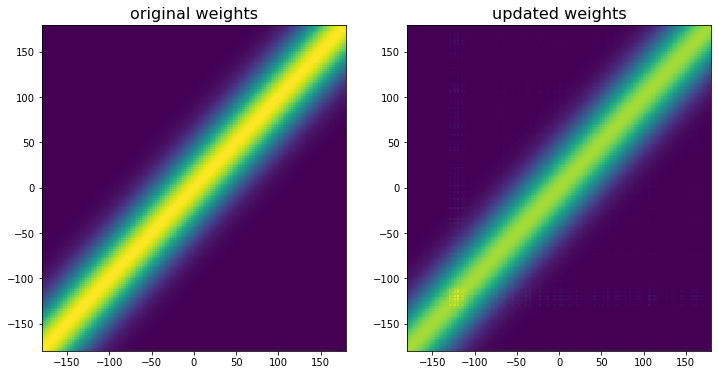

In [142]:
# update weights (repeat N_RUNS times for visible effect)

N_RUNS = 100

act_norm = norm_activation(act)
weights = np.zeros([N_RUNS, initial_weights.shape[0], initial_weights.shape[1]])
weights[0] = initial_weights
for ii in range(1,N_RUNS):
    weights[ii] = update_weights(weights[ii-1], act_norm, beta=5.28E-7, alpha=0.2)
    
    
# plot weights
fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].pcolormesh(PREF_DIRS, PREF_DIRS, initial_weights)
ax[0].set_title('original weights', fontsize=16)

# plot weights
ax[1].pcolormesh(PREF_DIRS, PREF_DIRS, weights[N_RUNS-1])
ax[1].set_title('updated weights', fontsize=16)

plt.show()

### Estimated Movement Vector
#### equation (13) 

[Georgopoulos, 1988](https://www.jneurosci.org/content/8/8/2928)


In [18]:
def decode_output(firing_rates, pref_dirs):
    # convert to radians, decode output
    x_comp = np.sum(firing_rates*np.cos(np.radians(pref_dirs)))
    y_comp = np.sum(firing_rates*np.sin(np.radians(pref_dirs)))
    output = np.degrees(np.arctan2(y_comp, x_comp))
        
    return output


## Build Adaptive Baysian model

In [136]:
# begin by building model with fixed weights

def calc_firing_rates(firing_rates, theta, pref_dirs, weights, 
                     baseline=5, gain=13.4, spread=18.9):
    
    # calc total activation
    activation = total_activation(firing_rates, weights, theta, pref_dirs, 
                                  baseline=baseline, gain=gain, spread=spread)

    # normalize activation
    firing_rates = norm_activation(activation)
    
    return firing_rates
       
def run_trial(initial_weights, pref_dirs, theta, n_iterations=5,
              baseline=5, gain=13.4, spread=18.9,
              beta=5.28E-7, alpha=0.2):
    
    # initial conditions
    firing_rates = np.zeros([n_iterations+1, len(pref_dirs)])
    weights = np.zeros([n_iterations+1, initial_weights.shape[0], initial_weights.shape[1]])
    weights[0] = initial_weights

    # run 5 iterations
    for ii in np.arange(1,n_iterations+1):
        firing_rates[ii] = calc_firing_rates(firing_rates[ii-1], theta, pref_dirs, weights[ii-1],
                                            baseline=baseline, gain=gain, spread=spread)
        weights[ii] = update_weights(weights[ii-1], firing_rates[ii-1], beta=beta, alpha=alpha)
        
    # decode output
    output = decode_output(firing_rates[5], pref_dirs)
    
    return output, firing_rates, weights
   

In [146]:
# run an example trial

# define parameters
TARGET = 45 # input angle

# define initial weight matrix
initial_weights = calc_initial_weights(PREF_DIRS, spread=38.8)

# run trial
output, firing_rates, weights = run_trial(initial_weights, PREF_DIRS, TARGET,
                                          baseline=0, gain=1E3, spread=30,
                                          beta=1E-5, alpha=1E-3)

# print results
print('Target angle: %d\N{DEGREE SIGN}' %TARGET)
print('Decoded movement angle: %0.2f\N{DEGREE SIGN}' %output)


Target angle: 45°
Decoded movement angle: 44.90°


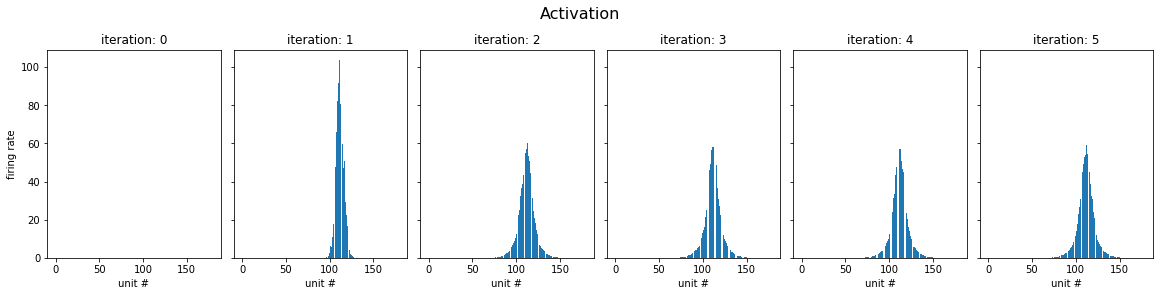

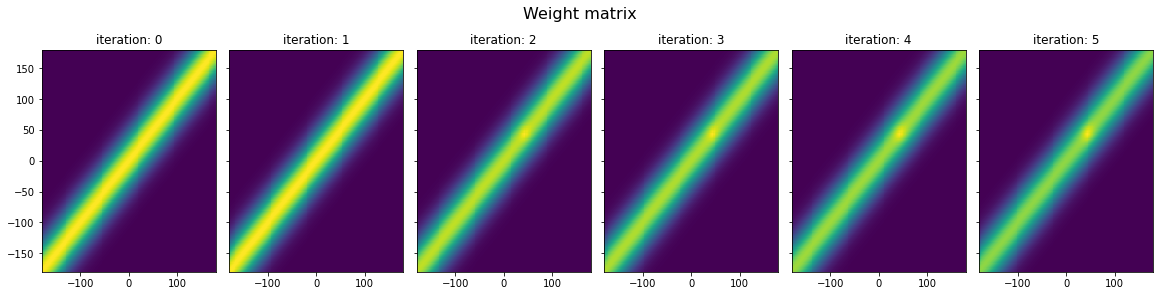

In [147]:
def plot_trial(firing_rates, weights, pref_dirs):
    # plot evolution of firing rates
    fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all', constrained_layout=True)
    fig.suptitle('Activation', fontsize=16)
    ax[0].set(ylabel='firing rate')
    for i in range(firing_rates.shape[0]):
        # plot
        ax[i].bar(np.arange(N_UNITS), firing_rates[i])

        #label
        ax[i].set(xlabel='unit #')
        ax[i].set(title='iteration: %d' %i)
    plt.show()

    # plot evolution of weights
    fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all', constrained_layout=True)
    fig.suptitle('Weight matrix', fontsize=16)
    for i in range(firing_rates.shape[0]):
        ax[i].pcolormesh(pref_dirs, pref_dirs, weights[i])
        ax[i].set(title='iteration: %d' %i)
    plt.show()
    
plot_trial(firing_rates, weights, PREF_DIRS)

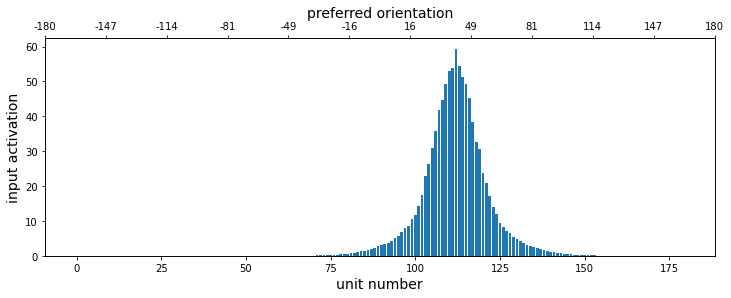

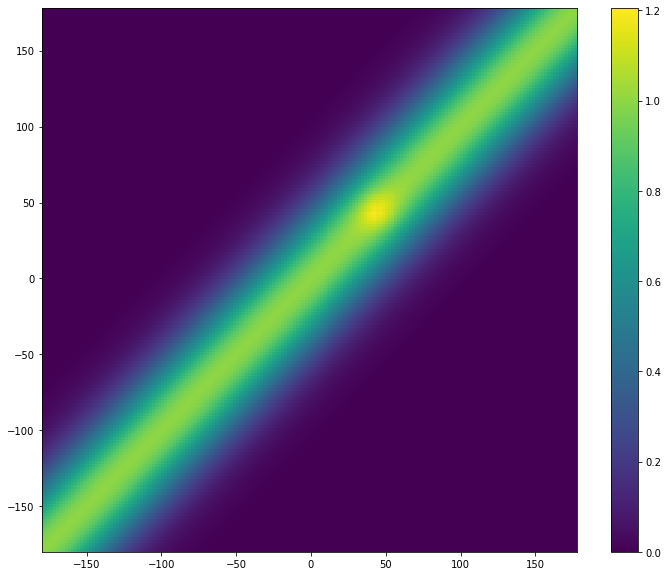

In [148]:
# plot final firing rates and weights on final interation of trial

# plot firing rates
# create figure
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
# plot data
ax1.bar(np.arange(N_UNITS), firing_rates[5])
# label plot
ax1.set_xlabel('unit number', fontsize=14)
ax1.set_ylabel('input activation', fontsize=14)
# add second x label
xx = np.linspace(pref_dirs[0],-pref_dirs[0], 12)
ax2.set_xticks(xx)
ax2.set_xticklabels([str(int(x)) for x in xx] )
ax2.set_xlabel('preferred orientation', fontsize=14)

# plot final weights
plt.figure(figsize=[12,10])
plt.pcolormesh(pref_dirs, pref_dirs, weights[5])
plt.colorbar()
plt.show()

## Test it!

#### Let's run some consecutive trials

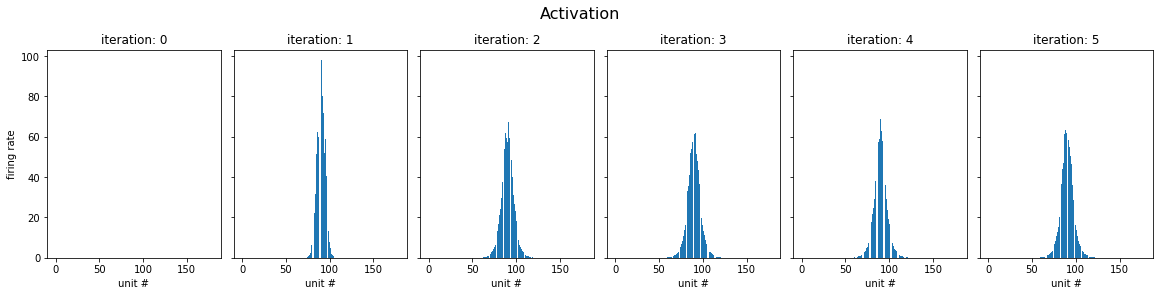

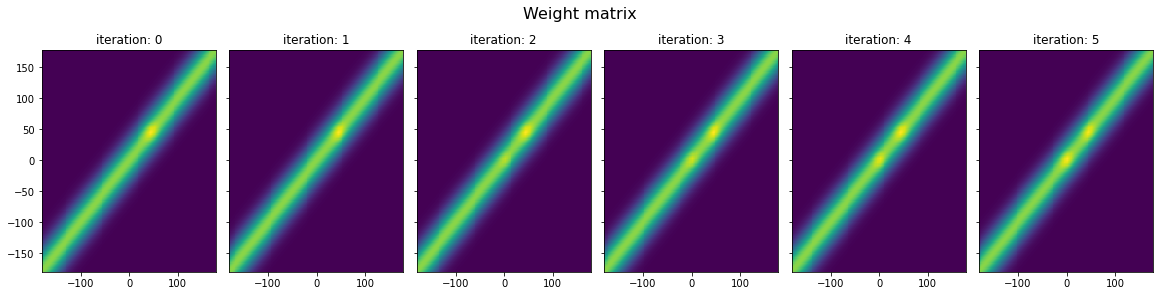

In [23]:
# run an example second trial

TARGET = 0

# run trial 2
output, firing_rates_2, weights_2 = run_trial(weights[5], PREF_DIRS, TARGET)

# plot
plot_trial(firing_rates_2, weights_2, PREF_DIRS)

#### Lets test some different context

create target distributions for diferent contexts

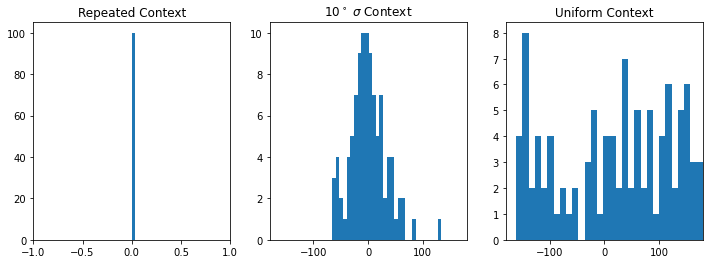

In [150]:
# parameteres
THETA = 0 # target angle for repeated context, and center of 10 degree context 
STD = 30 # standard deviation for 10 degree context 
N = 100 # number of trials

# generate distributions
distr_repeated = np.ones(N) * THETA
distr_10deg = np.random.normal(THETA, STD, N)
distr_uniform = np.random.rand(N) * 360 - 180

# plot 
n_bins = 30
titles = ['Repeated Context', '10$^\circ$ $\sigma$ Context', 'Uniform Context']
fig, ax = plt.subplots(1,3, figsize=[12,4])
ax[0].hist(distr_repeated, n_bins)
ax[1].hist(distr_10deg, n_bins)
ax[2].hist(distr_uniform, n_bins)

# set titles and axes limits
for ii, axes in enumerate(ax):
    axes.set(title=titles[ii], xlim=[-180,180])

# the repeated context distributin is not visible with mathed xlims
ax[0].set_xlim([-1,1])
    
plt.show()

#### run 100 trials with 10$^\circ$ context, then test

In [375]:
# run 100 trials

# define initial weight matrix
initial_weights = calc_initial_weights(PREF_DIRS, spread=30)

# create empty vars to populate
output = np.zeros(N)
firing_rates = np.zeros([N, len(PREF_DIRS)])
weights = np.zeros([N, initial_weights.shape[0], initial_weights.shape[1]])

# run trials
for ii, target in enumerate(distr_10deg):
    # set weights
    if ii == 0 :
        W = initial_weights
    else:
        W = weights[ii-1]
    
    # run trial
    output[ii], _, weights_all = run_trial(W, PREF_DIRS, target,
                                           baseline=5, gain=13.4, spread=18.9,
                                           beta=5.28E-5, alpha=0.2)
    weights[ii] = weights_all[5]



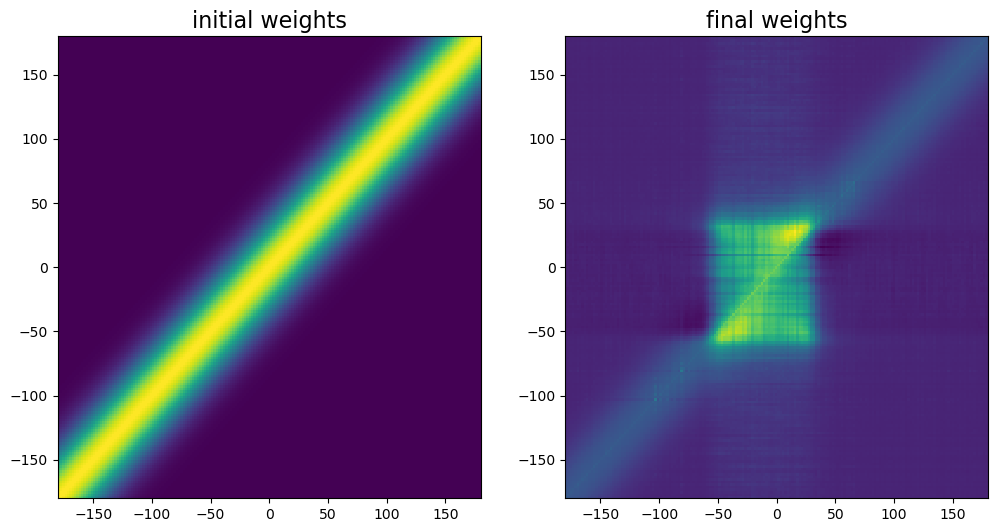

In [376]:
#plot final weight matrix

# plot weights
fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].pcolormesh(PREF_DIRS, PREF_DIRS, initial_weights)
ax[0].set_title('initial weights', fontsize=16)

# plot weights
ax[1].pcolormesh(PREF_DIRS, PREF_DIRS, weights[N-1])
ax[1].set_title('final weights', fontsize=16)
plt.show()

#### test all 3 contexts

In [42]:
def test_context(target_distr, pref_dirs):
    
    # define initial weight matrix
    initial_weights = calc_initial_weights(pref_dirs, spread=30)
    
    # create empty vars to populate
    n_targets = len(target_distr)
    firing_rates = np.zeros([n_targets, len(pref_dirs)])

    # run trials
    weights = initial_weights
    for ii, target in enumerate(target_distr):
        # run trial
        _, _, weights_trial = run_trial(weights, pref_dirs, target,
                                        baseline=0, gain=1E3, spread=30,
                                        beta=1E-6, alpha=1E-3)
        weights = weights_trial[5]

    return weights
    

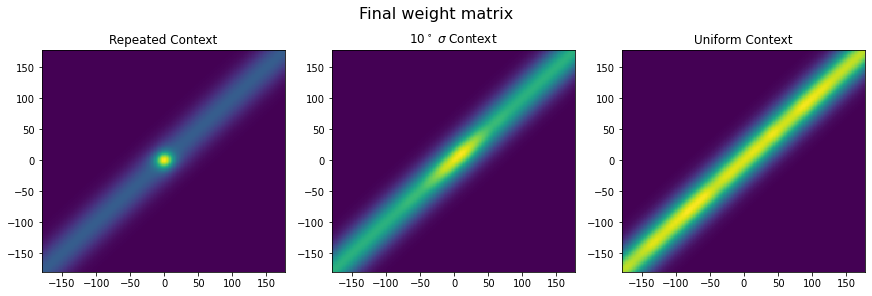

In [43]:
# test contexts and plot final weight matrix

final_weights = []
fig, ax = plt.subplots(1,3,figsize=[12,4], constrained_layout=True)
plt.suptitle('Final weight matrix', fontsize=16)
for ii, target_distr in enumerate([distr_repeated, distr_10deg, distr_uniform]):
    final_weights.append(test_context(target_distr, PREF_DIRS))
                         
    # plot final weights
    ax[ii].pcolormesh(PREF_DIRS, PREF_DIRS, final_weights[ii])
    ax[ii].set_title(titles[ii])
plt.show()

#### now probe the 3 resulting weight matrices

In [155]:
# run an example trial
TARGET = THETA # probe with center of context distribution

# run trial
output = np.zeros(len(final_weights))
for ii, W in enumerate(final_weights):
    output[ii], _, _= run_trial(W, PREF_DIRS, TARGET)

    # calc error
    error[ii] = np.mean(np.abs(output[ii] - TARGET))  

# print results
print('Target location: %d\N{DEGREE SIGN}' %TARGET)
print('Decoded movement angle:')
contexts = ['repeated context','%d\N{DEGREE SIGN} context' %STD,'uniform context']
for ii, context in enumerate(contexts):
    print('      %s: %0.2f\N{DEGREE SIGN}' %(context, error[ii]))


Target location: 0°
Decoded movement angle:
      repeated context: 1.01°
      30° context: 3.64°
      uniform context: 3.29°


as expected, the repeated context improves accuracy

# Run experiments

### test effect of context variance on response variability and error

#### create contexts and plot distributions

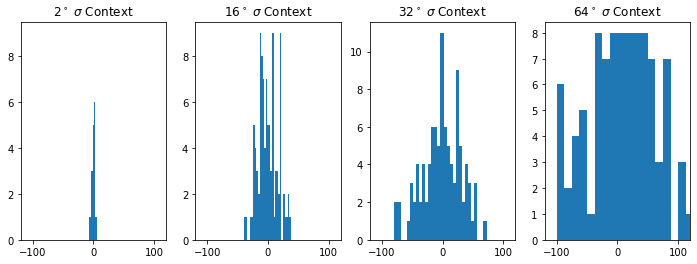

In [157]:
# parameteres
THETA = 0 # target angle for repeated context, and center of 10 degree context 
STD = [2, 16, 32, 64] # standard deviation for context distribution
N = 100 # number of trials

# create figure 
n_bins = 30
fig, ax = plt.subplots(1,len(STD), figsize=[12,4])

# generate disributions and plot
distr = np.zeros([len(STD), N])
for ii, std in enumerate(STD):
    # generate distributions
    distr[ii] = np.random.normal(THETA, std, N)

    # plot
    ax[ii].hist(distr[ii], n_bins)
    ax[ii].set(title='%d$^\circ$ $\sigma$ Context' %std, xlim=[-120,120])

plt.show()

#### test contexts and plot final weight matrix

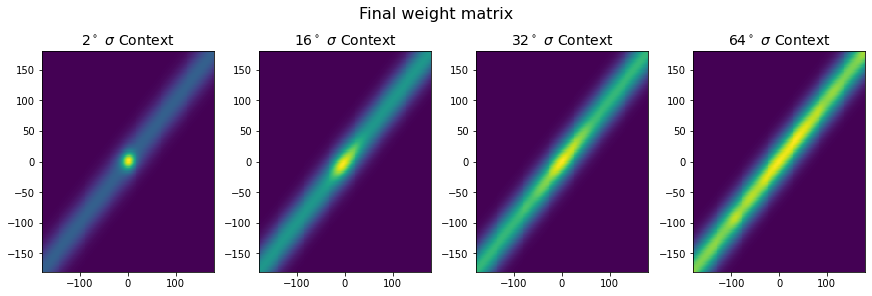

In [158]:
# test contexts and plot final weight matrix

final_weights = []

# create figure
fig, ax = plt.subplots(1,len(distr),figsize=[12,4], constrained_layout=True)
plt.suptitle('Final weight matrix', fontsize=16)

# test each distribution
for ii in range(len(distr)):
    final_weights.append(test_context(distr[ii], PREF_DIRS))
                         
    # plot final weights
    ax[ii].pcolormesh(PREF_DIRS, PREF_DIRS, final_weights[ii])
    ax[ii].set_title('%d$^\circ$ $\sigma$ Context' %STD[ii], size=14)
    ax[ii].set(xlim=[-180,180])
plt.show()

#### probe the resulting matrices (with context angle)
effect of context variance on response variance

Standard Deviation of decoded movement angle:
      2° context: 0.0204
      16° context: 0.4496
      32° context: 1.3514
      64° context: 2.1869


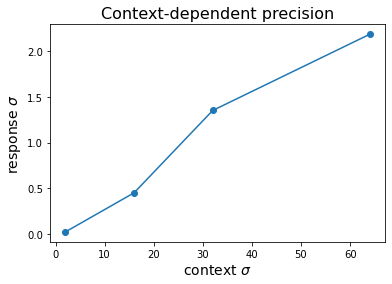

In [159]:
N_RUNS = 100 # number of probe trials

# print results
print('Standard Deviation of decoded movement angle:')

# run trials
output_0 = np.zeros([len(final_weights), N_RUNS])
variance = np.zeros([len(final_weights)])
for ii, W in enumerate(final_weights):
    for jj in range(N_RUNS):
        # run trial
        output_0[ii,jj], _, _= run_trial(W, PREF_DIRS, THETA)
        
    # calc variance
    variance[ii] = output_0[ii].std()
    print('      %d\N{DEGREE SIGN} context: %0.4f' %(STD[ii], variance[ii]))

# plot results
plt.figure()
plt.scatter(STD, variance)
plt.plot(STD, variance)
plt.xlabel('context $\sigma$', fontsize=14)
plt.ylabel('response $\sigma$', fontsize=14)
plt.title('Context-dependent precision', fontsize=16)
plt.show()

#### probe the resulting matrices (with similar angle to context angle)
effect of context variance on reponse flexibility/bias

Error in decoded movement angle:
      2° context: 36.17
      16° context: 25.75
      32° context: 12.67
      64° context: 3.00


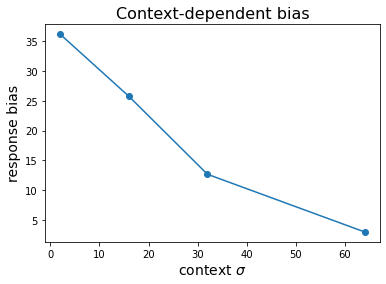

In [160]:
PROBE = 40 # target on probe trial
N_RUNS = 100 # number of probe trials

# print results
print('Error in decoded movement angle:')

# run trials
output_1 = np.zeros([len(final_weights), N_RUNS])
error = np.zeros([len(final_weights)])
for ii, W in enumerate(final_weights):
    for jj in range(N_RUNS):
        # run trial
        output_1[ii,jj], _, _= run_trial(W, PREF_DIRS, PROBE)
    # calc error
    error[ii] = np.mean(np.abs(output_1[ii] - PROBE))    
    print('      %d\N{DEGREE SIGN} context: %0.2f' %(STD[ii], error[ii]))

# plot results
plt.figure()
plt.scatter(STD, error)
plt.plot(STD, error)
plt.xlabel('context $\sigma$', fontsize=14)
plt.ylabel('response bias', fontsize=14)
plt.title('Context-dependent bias', fontsize=16)
plt.show()

## replicate figure 7

create context distributions

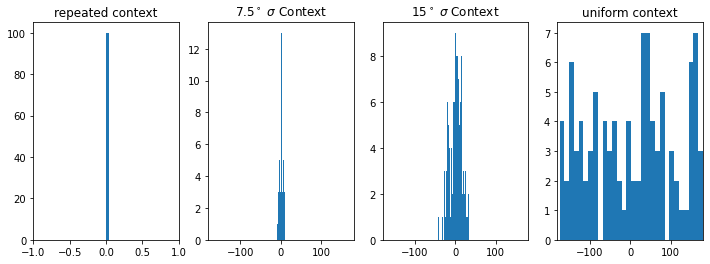

In [168]:
# parameters
THETA = 0 # center of context distr
N = 100 # number of trials

# generate distributions
distr = np.zeros([4, N])
distr[0] = np.ones(N) * THETA # repeated 
distr[3] = np.random.rand(N) * 360 - 180 # uniform
distr[1] = np.random.normal(THETA, 7.5, N) # 
distr[2] = np.random.normal(THETA, 15, N) # 

# create figure 
n_bins = 30
fig, ax = plt.subplots(1,len(STD), figsize=[12,4])

# plot
title=['repeated context', 
       '7.5$^\circ$ $\sigma$ Context',
       '15$^\circ$ $\sigma$ Context',
       'uniform context']

for ii, std in enumerate(STD):
    # plot
    ax[ii].hist(distr[ii], n_bins)
    ax[ii].set(title=title[ii], xlim=[-180,180])
ax[0].set(xlim=[-1,1])

plt.show()

get final weight matrices

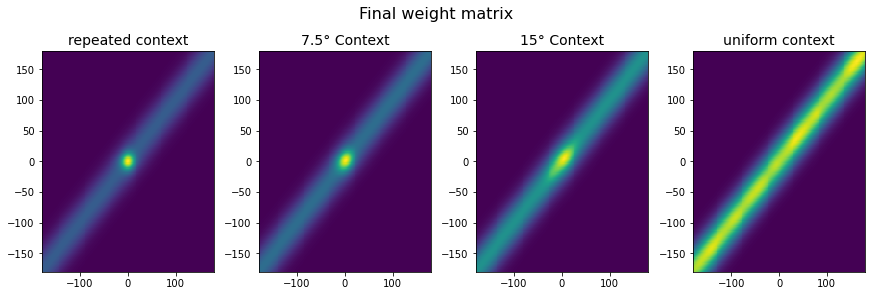

In [192]:
# test contexts and plot final weight matrix

final_weights = []

# create figure
fig, ax = plt.subplots(1,len(distr),figsize=[12,4], constrained_layout=True)
plt.suptitle('Final weight matrix', fontsize=16)

# test each distribution
for ii in range(len(distr)):
    final_weights.append(test_context(distr[ii], PREF_DIRS))
                         
    # plot final weights
    ax[ii].pcolormesh(PREF_DIRS, PREF_DIRS, final_weights[ii])
    ax[ii].set_title(title[ii], size=14)
    ax[ii].set(xlim=[-180,180])
plt.show()

run probe trials

In [193]:
# parameters
PROBE = [0, 30, 60, 90] # probe distance
N_RUNS = 100 # number of probe trials


title=['repeated context', 
       '7.5\N{DEGREE SIGN} Context',
       '15\N{DEGREE SIGN} Context',
       'uniform context']

# run trials
output_6b = np.zeros([len(final_weights), len(PROBE), N_RUNS])
error = np.zeros([len(final_weights), len(PROBE)])
variance = np.zeros([len(final_weights), len(PROBE)])

for ii, W in enumerate(final_weights):
    print(title[ii])
    for jj, probe in enumerate(PROBE):
        for n in range(N_RUNS):
            # run trial
            output_6b[ii,jj,n], _, _= run_trial(W, PREF_DIRS, probe)
            continue 
            
        # calc error
        error[ii,jj] = np.mean(np.abs(output_6b[ii,jj] - probe)) 
        print('     probe distance=%d: %0.2f' %(probe, error[ii,jj]))

        # calc variance
        variance[ii,jj] = output_6b[ii,jj].std()
        print('      probe distance=%d: %0.4f' %(probe, variance[ii,jj]))


repeated context
     probe distance=0: 0.03
      probe distance=0: 0.0176
     probe distance=30: 28.91
      probe distance=30: 0.3167
     probe distance=60: 40.85
      probe distance=60: 13.1069
     probe distance=90: 22.68
      probe distance=90: 26.8677
7.5° Context
     probe distance=0: 1.02
      probe distance=0: 0.0495
     probe distance=30: 27.25
      probe distance=30: 0.3668
     probe distance=60: 36.81
      probe distance=60: 12.6754
     probe distance=90: 19.86
      probe distance=90: 24.1151
15° Context
     probe distance=0: 1.77
      probe distance=0: 0.4807
     probe distance=30: 21.58
      probe distance=30: 0.9757
     probe distance=60: 27.20
      probe distance=60: 9.6130
     probe distance=90: 9.52
      probe distance=90: 14.0308
uniform context
     probe distance=0: 3.52
      probe distance=0: 3.4886
     probe distance=30: 3.12
      probe distance=30: 2.2513
     probe distance=60: 3.57
      probe distance=60: 2.7662
     probe distance=90

plot results

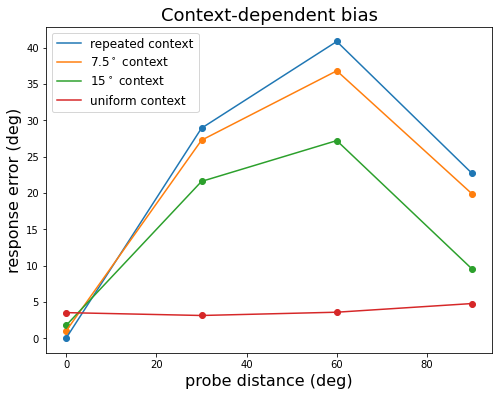

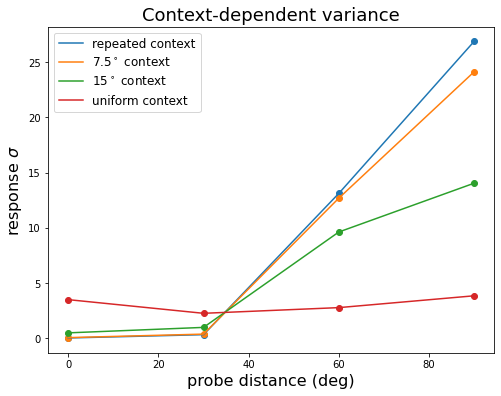

In [259]:
# plot results
plt.figure(figsize=[8,6])
for ii in range(len(distr)):
    plt.scatter(PROBE, error[ii])
    plt.plot(PROBE, error[ii])

plt.legend(['repeated context','7.5$^\circ$ context',
            '15$^\circ$ context','uniform context'], 
           fontsize=12, loc='upper left')
plt.xlabel('probe distance (deg)', fontsize=16)
plt.ylabel('response error (deg)', fontsize=16)
plt.title('Context-dependent bias', fontsize=18)
plt.show()

# plot results
plt.figure(figsize=[8,6])
for ii in range(len(distr)):
    plt.scatter(PROBE, variance[ii])
    plt.plot(PROBE, variance[ii])

plt.legend(['repeated context','7.5$^\circ$ context',
            '15$^\circ$ context','uniform context'],
           fontsize=12, loc='upper left')
plt.xlabel('probe distance (deg)', fontsize=16)
plt.ylabel('response $\sigma$', fontsize=16)
plt.title('Context-dependent variance', fontsize=18)
plt.show()

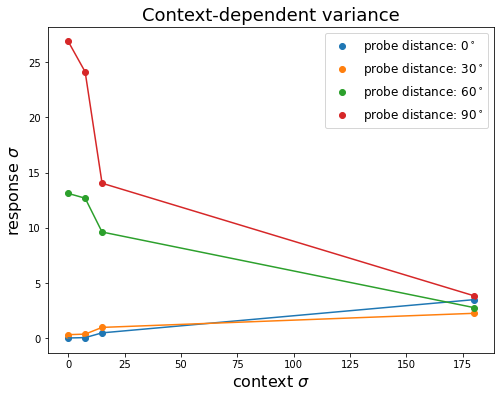

In [260]:
X = [0,7.5,15,180]

# plot results
plt.figure(figsize=[8,6])
for ii in range(len(distr)):
    plt.scatter(X, variance[:,ii], label='probe distance: %d$^\circ$' %PROBE[ii])
    plt.plot(X, variance[:,ii])

plt.legend(fontsize=12, loc='upper right')
plt.xlabel('context $\sigma$', fontsize=16)
plt.ylabel('response $\sigma$', fontsize=16)
plt.title('Context-dependent variance', fontsize=18)
plt.show()


# Let's make some GIFs!

generate distributions for 3 conext type

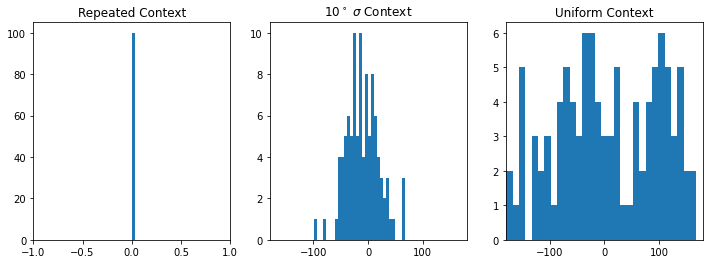

In [268]:
# parameteres
THETA = 0 # target angle for repeated context, and center of 10 degree context 
STD = 30 # standard deviation for 10 degree context 
N = 100 # number of trials

# generate distributions
distr_repeated = np.ones(N) * THETA
distr_10deg = np.random.normal(THETA, STD, N)
distr_uniform = np.random.rand(N) * 360 - 180

# plot 
n_bins = 30
titles = ['Repeated Context', '10$^\circ$ $\sigma$ Context', 'Uniform Context']
fig, ax = plt.subplots(1,3, figsize=[12,4])
ax[0].hist(distr_repeated, n_bins)
ax[1].hist(distr_10deg, n_bins)
ax[2].hist(distr_uniform, n_bins)

# set titles and axes limits
for ii, axes in enumerate(ax):
    axes.set(title=titles[ii], xlim=[-180,180])

# the repeated context distributin is not visible with mathed xlims
ax[0].set_xlim([-1,1])
    
plt.show()

In [436]:
# run 100 trials

# directory for figure output
dir_fig = 'C:/Users/micha/verstynen_2011_rpl/figures/gif_1_frames_fastlearning'

# figure appearnce for gif
plt.rc('axes', titlesize=64)
plt.rc('axes', titlepad=64)

plt.rc('axes', labelsize=42)
plt.rc('axes', labelpad=12)

plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)

# combine distributions into 1 variable
distributions = [distr_repeated, distr_10deg, distr_uniform]

# define initial weight matrix
initial_weights = calc_initial_weights(PREF_DIRS)
weights = [initial_weights]*4

# create empty vars to populate
output = np.zeros([N, len(distributions)])
error = np.zeros([N, len(distributions)])

# run trials
trial_num = np.linspace(0,N-1,N)
for ii in range(N):
    # display progress
    clear_output(wait=True)
    print('plotting trial: %d' %ii)
    
    # create figure
    fig, ax = plt.subplots(4,3, figsize=[32,24], constrained_layout=True)
    
    for jj, distr in enumerate(distributions):        
        # create empty vars to populate
        firing_rates = np.zeros([len(distributions), len(PREF_DIRS)])

        # run trial
        output[ii,jj], \
        firing_rates_trial, \
        weights_trial = run_trial(weights[jj], PREF_DIRS, distr[ii],
                                  baseline=5, gain=13.4, spread=18.9,
                                  beta=1E-6, alpha=1E-3)
                                  #beta=5.28E-7, alpha=0.23)
        
        firing_rates[jj] = firing_rates_trial[5]
        weights[jj] = weights_trial[5]
        error[ii,jj] = np.abs(distr[ii] - output[ii,jj])
        
        # plot targets
        ax[0, jj].plot(trial_num[:ii+1], distributions[jj][:ii+1])
        ax[0, jj].scatter(trial_num[:ii+1], distributions[jj][:ii+1])
        ax[0, jj].set(xlim=[0,100], ylim=[-180,180])

        # plot activation
        ax[1, jj].bar(PREF_DIRS, firing_rates[jj])
        ax[1, jj].set(xlim=[-180,180], ylim=[0,30])
        # plot output
        ax[1, jj].axvline(output[ii,jj], color='k',linestyle='-')

        # plot error
        ax[2, jj].plot(trial_num[:ii+1], error[:ii+1,jj])
        ax[2, jj].scatter(trial_num[:ii+1], error[:ii+1,jj])
        ax[2, jj].set(xlim=[0,100], ylim=[0,55])
        # plot mean error
        ax[2, jj].text(5, 48, 'mean error: %0.2f$^\circ$'%(np.mean(error[:ii+1,jj])), fontsize=42, color='k')
        ax[2, jj].axhline(np.mean(error[:ii+1,jj]), color='r',linestyle='--')

        # plot weights
        ax[3, jj].pcolormesh(PREF_DIRS, PREF_DIRS, weights[jj])
        lim = 180
        ax[3, jj].set(xlim=[-lim,lim], ylim=[-lim,lim])
        
    # label plots (rows)
    ax[0, 0].set_ylabel('Target angle')
    ax[1, 0].set_ylabel('Firing rate')    
    ax[2, 0].set_ylabel('Response error')
    ax[3, 0].set_ylabel('Weight matrix')

    # label plots (columns)
    ax[0,0].set_title('Repeated context')
    ax[0,1].set_title('10$^\circ$ context')    
    ax[0,2].set_title('Uniform context')
    
    # algin ylables
    fig.align_ylabels(ax[:, 0])
    
    # save frame
    fname_fig = 'trial_%d.png' %ii
    plt.savefig(join(dir_fig, fname_fig))
    plt.close('all')
    
# display progress
clear_output(wait=True)
print('GIFSKI!')

GIFSKI!


add extra frames at the end

In [447]:
from shutil import copyfile

for ii in range(N,N+9):
    copyfile(join(dir_fig, 'trial_%d.png' %(N-1)), join(dir_fig, 'trial_%d.png' %ii))

just some code to tweak plotting appearance 

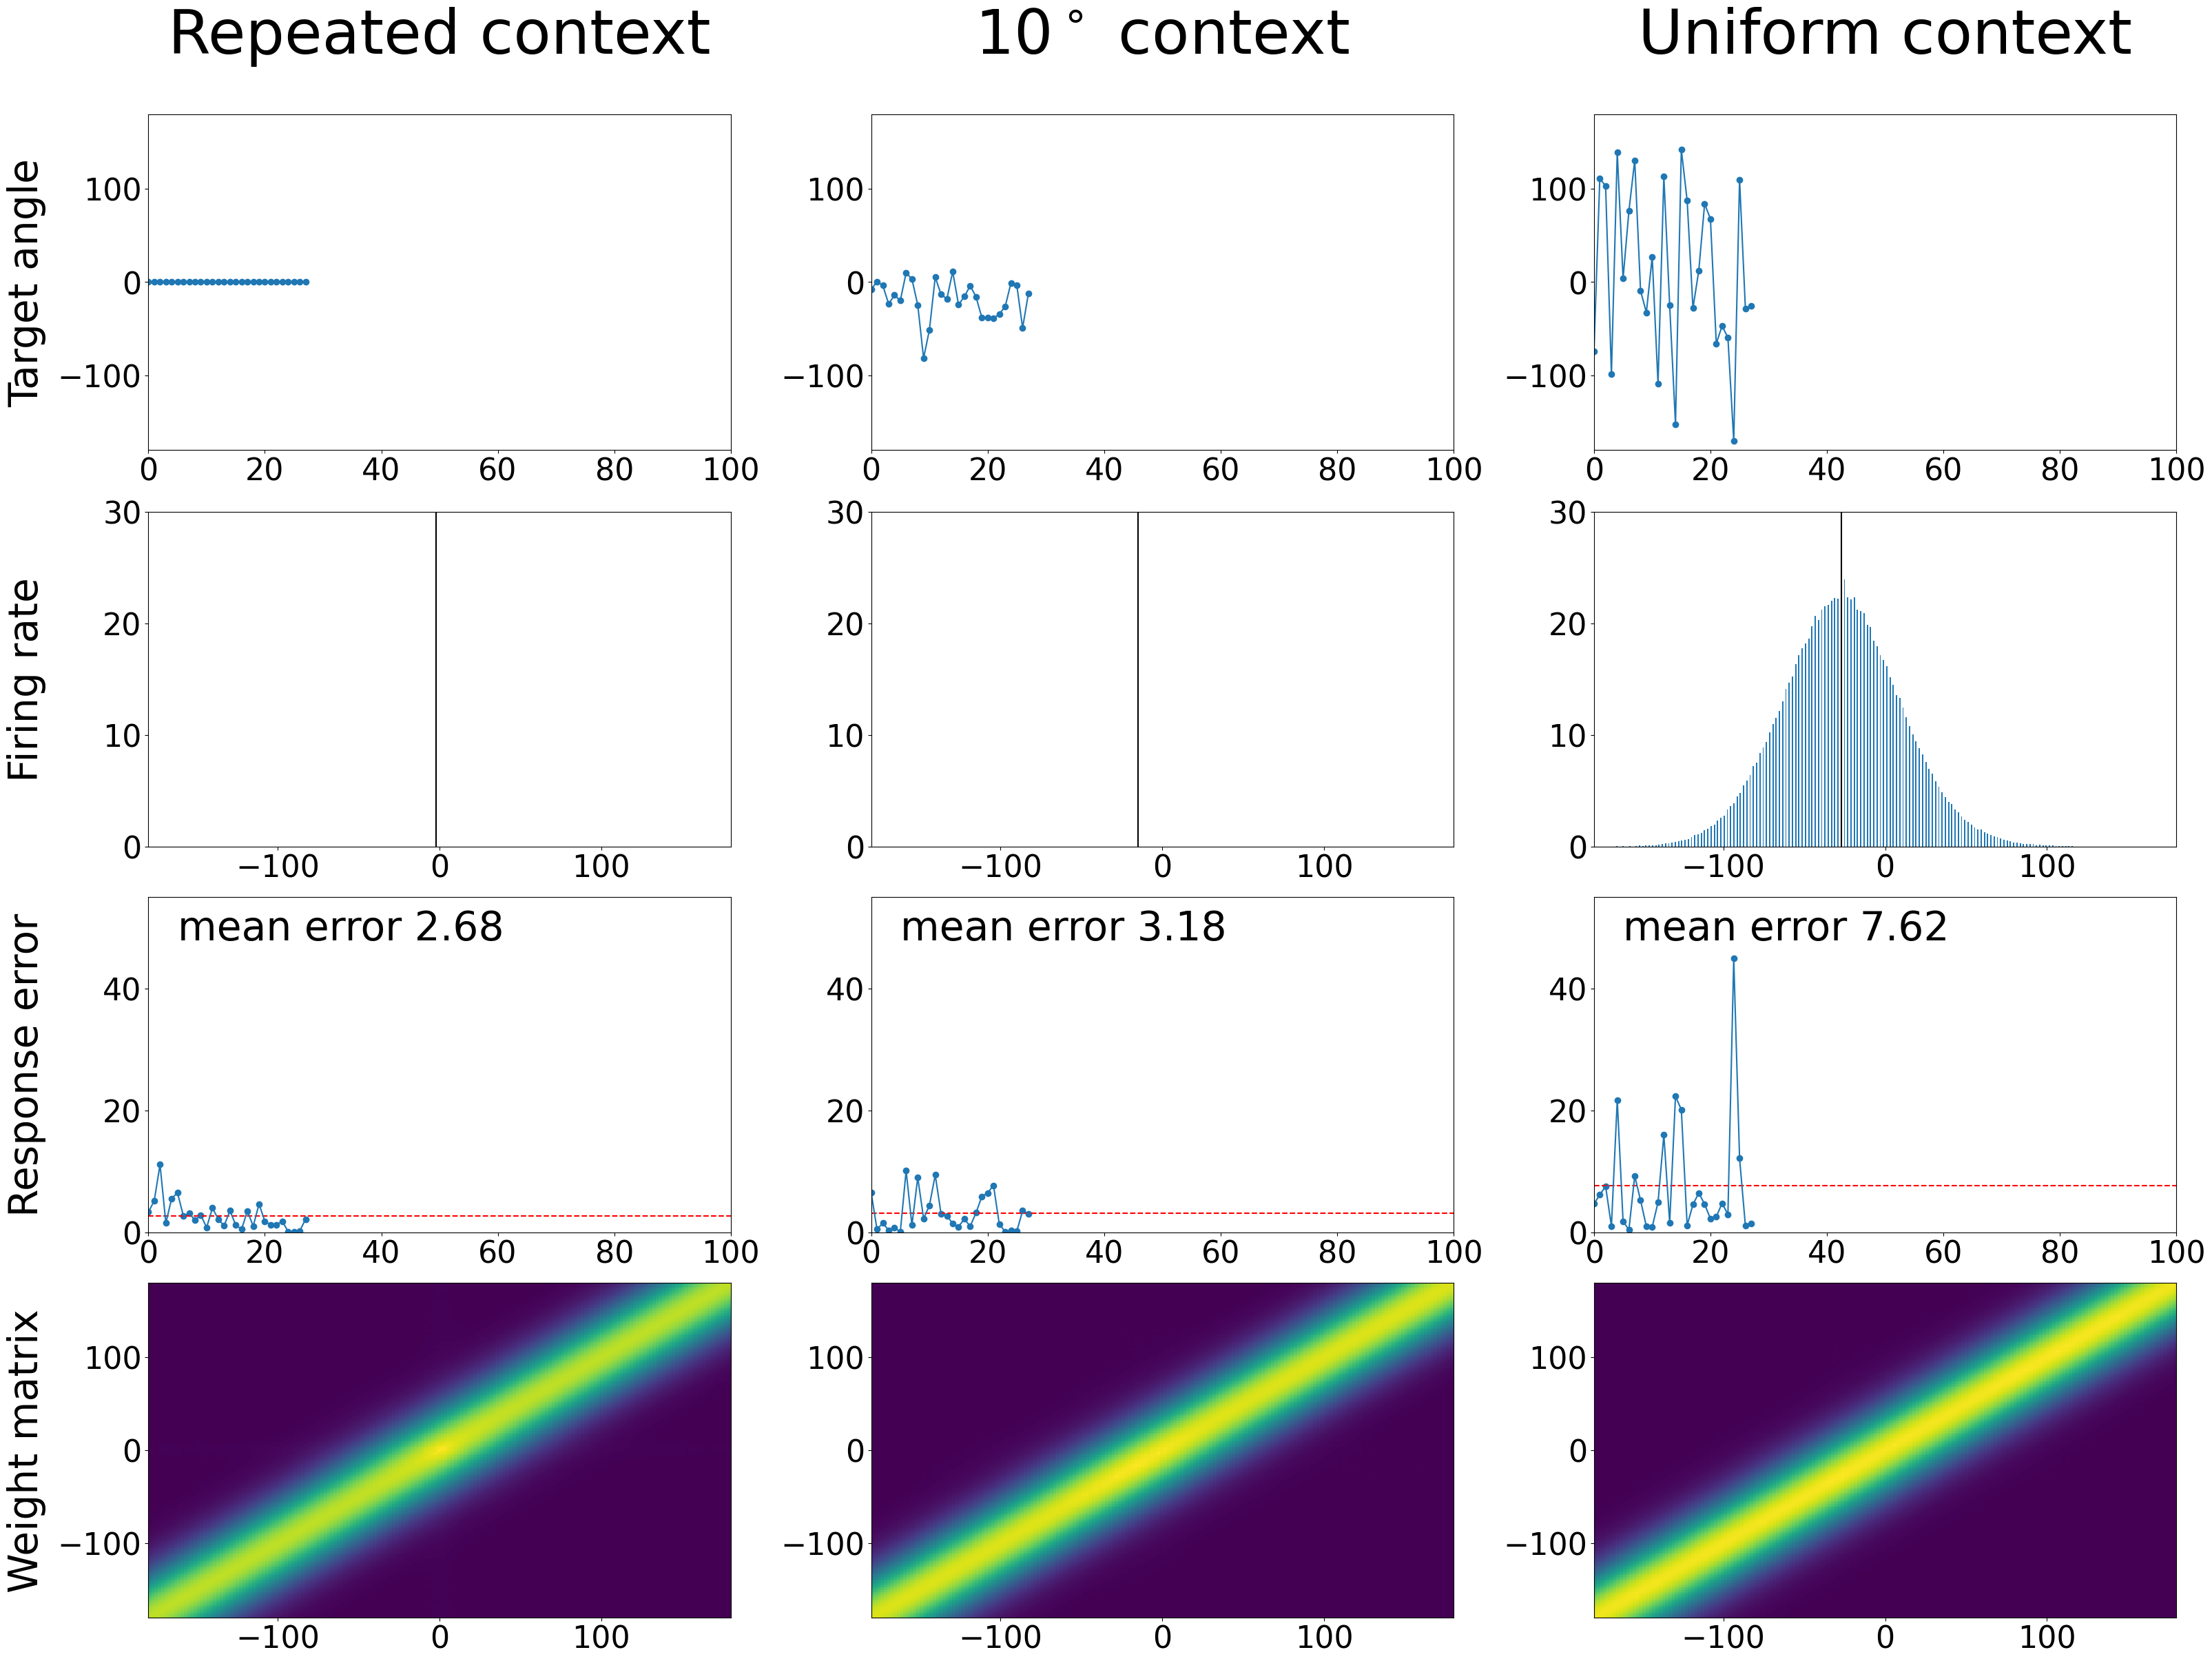

In [435]:
plt.rc('axes', titlesize=64)
plt.rc('axes', titlepad=64)

plt.rc('axes', labelsize=42)
plt.rc('axes', labelpad=12)

plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)

# create figure
fig, ax = plt.subplots(4,3, figsize=[32,24], constrained_layout=True)

for jj, distr in enumerate(distributions):        

    # plot targets
    ax[0, jj].plot(trial_num[:ii+1], distributions[jj][:ii+1])
    ax[0, jj].scatter(trial_num[:ii+1], distributions[jj][:ii+1])
    ax[0, jj].set(xlim=[0,100], ylim=[-180,180])

    # plot activation
    ax[1, jj].axvline(output[ii,jj], color='k',linestyle='-')
    ax[1, jj].bar(PREF_DIRS, firing_rates[jj])
    ax[1, jj].set(xlim=[-180,180], ylim=[0,30])

    # plot error
    ax[2, jj].text(5, 48, 'mean error %0.2f'%(np.mean(error[:ii+1,jj])), fontsize=42, color='k')
    ax[2, jj].axhline(np.mean(error[:ii+1,jj]), color='r',linestyle='--')
    ax[2, jj].plot(trial_num[:ii+1], error[:ii+1,jj])
    ax[2, jj].scatter(trial_num[:ii+1], error[:ii+1,jj])
    ax[2, jj].set(xlim=[0,100], ylim=[0,55])

    # plot weights
    ax[3, jj].pcolormesh(PREF_DIRS, PREF_DIRS, weights[jj])
    lim = 180
    ax[3, jj].set(xlim=[-lim,lim], ylim=[-lim,lim])

# label plots (rows)
rot = 90
ax[0, 0].set_ylabel('Target angle', rotation=rot)
ax[1, 0].set_ylabel('Firing rate', rotation=rot)    
ax[2, 0].set_ylabel('Response error', rotation=rot)
ax[3, 0].set_ylabel('Weight matrix', rotation=rot)

# label plots (columns)
ax[0,0].set_title('Repeated context')
ax[0,1].set_title('10$^\circ$ context')    
ax[0,2].set_title('Uniform context')

# algin ylables
fig.align_ylabels(ax[:, 0])
plt.show()